## 匯入相關套件

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn

import time
import math
import os
from datetime import datetime

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")  

In [2]:
# 確認是否可以使用 GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu_available = torch.cuda.is_available()

## 自定義函式、類別

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim 
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        
        return out

In [4]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device).requires_grad_()
        
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        
        return out

In [5]:
# 取出股票
def stock(id):
    
    stockdate = f[f['name']==str(id)].loc[:,'date']
    stockdf = f[f['name']==str(id)].dropna(axis=1).loc[:,'open':'volume']
    #print(df)
    
    return stockdf, stockdate

In [6]:
# 分割訓練測試資料
def split_data(stock, lookback, gapspace=0, test_set_size=120):
    
    # data_raw = stock.to_numpy() # convert to numpy array
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback,:])
    
    data = np.array(data);

    # test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1-gapspace,:]
    y_train = data[:train_set_size,-1,3:4]
    x_test = data[train_set_size:,:-1-gapspace,:]
    y_test = data[train_set_size:,-1,3:4]
    
    print('x_train.shape = ',x_train.shape)
    print('y_train.shape = ',y_train.shape)
    print('x_test.shape = ',x_test.shape)
    print('y_test.shape = ',y_test.shape)
  
    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    y_train= torch.from_numpy(y_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_test= torch.from_numpy(y_test).type(torch.Tensor)
            
    x_train = x_train.to(device)
    y_train= y_train.to(device)
    x_test = x_test.to(device)
    y_test= y_test.to(device)
        
    return x_train, y_train, x_test, y_test

In [7]:
def model_train_predict(epochs=500, model_name = 'LSTM'):
      
    mseloss_train = np.zeros(epochs)
    mseloss_test = np.zeros(epochs)
    all_y_train_pred = []
    all_y_test_pred = []
    
    if model_name == 'LSTM':
        
        model = LSTM(input_dim=df.shape[1], hidden_dim=32, output_dim=1, num_layers=2)
        model = model.to(device)
        
        criterion = torch.nn.MSELoss(reduction='mean')
        optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
     
    if model_name == 'GRU':
        
        model = GRU(input_dim=df.shape[1], hidden_dim=32, output_dim=1, num_layers=2)
        model = model.to(device)

        criterion = torch.nn.MSELoss(reduction='mean')
        optimiser = torch.optim.Adam(model.parameters(), lr=0.01)    

    for i in range(epochs):

        y_train_pred = model(x_train)
        loss = criterion(y_train_pred, y_train) 
        if (i+1)%10 == 0:
            print("Epoch ", i+1, "MSE: ", loss.item())
        mseloss_train[i] = loss.item()

        if gpu_available == False:  
            all_y_train_pred.append(scalertar.inverse_transform(y_train_pred.detach().numpy()))    
        else:
            all_y_train_pred.append(scalertar.inverse_transform(y_train_pred.cpu().detach().numpy()))                

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        y_test_pred = model(x_test)
        losst = criterion(y_test_pred, y_test) 
        mseloss_test[i] = losst.item()

        if gpu_available == False:
            all_y_test_pred.append(scalertar.inverse_transform(y_test_pred.detach().numpy()))
        else:
            all_y_test_pred.append(scalertar.inverse_transform(y_test_pred.cpu().detach().numpy()))
    
    if os.path.exists('data/model') is False:
        os.makedirs('data/model')
    
    # 模型存檔
    path = f'data/model/{model_name}_epoch{epochs}.pth'
    torch.save(model.state_dict(), path)
    
    return all_y_train_pred, all_y_test_pred, mseloss_train, mseloss_test

In [8]:
def Train_Data_Stock_Trend_Plot(y_train, y_train_pred):
    
    fig = plt.figure(figsize=(16, 12))

    # 日期格式修正
    x= [datetime.strptime(str(d), '%Y-%m-%d').date() for d in train_date_list]

    ax = sns.lineplot(x=x, y=y_train.ravel(), label="Historical Data", color='royalblue')
    ax = sns.lineplot(x=x, y=y_train_pred.ravel(), label= f'{model_name} Train Prediction', color='tomato')
    ax.set_title(f'{ID}  {model_name} Train Data Stock Trend', size = 20, fontweight='bold')
    ax.set_xlabel('Year', size = 18)
    ax.set_ylabel('Stock Price (TWD)', size = 18)
    ax.set_xticklabels('', size=10)
    plt.legend(fontsize='xx-large', loc='upper left')

    #设置 x 轴主刻度格式
    alldays =  mdates.YearLocator()                           #主刻度为每年
    ax.xaxis.set_major_locator(alldays)                       #设置主刻度
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 

    plt.legend(fontsize='xx-large', loc='upper left')
    plt.tick_params(labelsize = 16)
    #plt.gcf().autofmt_xdate()

    if os.path.exists('data/fig') is False:
        os.makedirs('data/fig')

    #plt.show()
    fig.savefig(f'data/fig/{ID}_{model_name}_Train_Data_Stock_Trend.png')

In [9]:
def Test_Data_Stock_Trend_Plot(y_test, y_test_pred):
    
    fig = plt.figure(figsize=(16, 12))

    x= [datetime.strptime(str(d), '%Y-%m-%d').date() for d in test_date_list]

    ax = sns.lineplot(x=x, y=y_test.ravel(), label='Historical Data')
    ax = sns.lineplot(x=x, y=y_test_pred.ravel(), label=f'{model_name} Test Prediction')
    ax.set_title(f'{ID}  {model_name} Test Data Stock Trend', size = 20, fontweight='bold')
    ax.set_xlabel('Month', size = 18)
    ax.set_ylabel('Stock price (TWD)', size = 18)

    alldays =  mdates.MonthLocator()                          
    ax.xaxis.set_major_locator(alldays)                       
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

    plt.legend(fontsize='xx-large', loc='upper left')
    plt.tick_params(labelsize=16)
    #plt.gcf().autofmt_xdate()

    if os.path.exists('data/fig') is False:
        os.makedirs('data/fig')

    #plt.show()
    fig.savefig(f'data/fig/{ID}_{model_name}_Test_Data_Stock_Trend.png')

In [10]:
def LSTM_GRU_Data_Stock_Trend_Plot(y_test, lstmdata, grudata):
    
    fig = plt.figure(figsize=(16, 12))

    x= [datetime.strptime(str(d), '%Y-%m-%d').date() for d in test_date_list]

    ax = sns.lineplot(x=x, y=y_test.ravel(), label='Historical Data')
    ax = sns.lineplot(x=x, y=lstmdata.ravel(), label=f'LSTM Test Prediction')
    ax = sns.lineplot(x=x, y=grudata.ravel(), label=f'GRU Test Prediction')
    ax.set_title(f'{ID}  Test Data Stock Trend', size = 20, fontweight='bold')
    ax.set_xlabel('Month', size = 18)
    ax.set_ylabel('Stock price (TWD)', size = 18)

    alldays =  mdates.MonthLocator()                          
    ax.xaxis.set_major_locator(alldays)                       
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

    plt.legend(fontsize='xx-large', loc='upper left')
    plt.tick_params(labelsize=16)
    #plt.gcf().autofmt_xdate()

    if os.path.exists('data/fig') is False:
        os.makedirs('data/fig')

    #plt.show()
    fig.savefig(f'data/fig/{ID}_Both_LSTM_GRU_Test_Data_Stock_Trend.png')

In [11]:
def RMSE_MSELOSS_Plot(allTrainRMSE, allTestRMSE, mseloss_train, mseloss_test):
    
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    plt.subplot(1, 2, 1)
    ax = sns.lineplot(data=allTrainRMSE, label='Train Data')
    ax = sns.lineplot(data=allTestRMSE, label='Test Data')
    ax.set_xlabel('Epoch', size = 16)
    ax.set_title(f'{ID}  {model_name} RMSE', size = 18, fontweight='bold')
    plt.tick_params(labelsize=14)
    plt.legend(fontsize='x-large', loc='upper right')

    plt.subplot(1, 2, 2)
    ax = sns.lineplot(data=mseloss_train, label='Train Data')
    ax = sns.lineplot(data=mseloss_test, label='Test Data')
    ax.set_xlabel('Epoch', size = 16)
    ax.set_title(f'{ID}  {model_name} MSE Loss', size = 18, fontweight='bold')
    plt.tick_params(labelsize=14)
    plt.legend(fontsize='x-large', loc='upper right')

    fig.set_figheight(6)
    fig.set_figwidth(16)
    
    if os.path.exists('data/fig') is False:
        os.makedirs('data/fig')

    #plt.show()
    fig.savefig(f'data/fig/{ID}_{model_name}_RMSE_MSELOSS.png')

In [12]:
# def LSTM_train_predict_tt(epochs=500):
      
#     mseloss_train = np.zeros(epochs)
#     mseloss_test = np.zeros(epochs)
#     all_y_train_pred = []
#     all_y_test_pred = []

#     for i in range(epochs):
        
#         y_train_pred = modelL(x_train)
#         loss = criterion(y_train_pred, y_train) 
#         if (i+1)%10 == 0:
#             print("Epoch ", i+1, "MSE: ", loss.item())
#         mseloss_train[i] = loss.item()
        
#         if gpu_available == False:  
#             all_y_train_pred.append(scalertar.inverse_transform(y_train_pred.detach().numpy()))    
#         else:
#             all_y_train_pred.append(scalertar.inverse_transform(y_train_pred.cpu().detach().numpy()))                
                         
#         optimiserL.zero_grad()
#         loss.backward()
#         optimiserL.step()
        
#         y_test_pred = modelL(x_test)
#         losst = criterion(y_test_pred, y_test) 
#         mseloss_test[i] = losst.item()
        
#         if gpu_available == False:
#             all_y_test_pred.append(scalertar.inverse_transform(y_test_pred.detach().numpy()))
#         else:
#             all_y_test_pred.append(scalertar.inverse_transform(y_test_pred.cpu().detach().numpy())) 
    
#     return all_y_train_pred, all_y_test_pred, mseloss_train, mseloss_test

In [13]:
# def GRU_train_predict_tt(epochs=500):
      
#     mseloss_train = np.zeros(epochs)
#     mseloss_test = np.zeros(epochs)
#     all_y_train_pred = []
#     all_y_test_pred = []

#     for i in range(epochs):
        
#         y_train_pred = modelG(x_train)
#         loss = criterion(y_train_pred, y_train) 
#         if (i+1)%10 == 0:
#             print("Epoch ", i+1, "MSE: ", loss.item())
#         mseloss_train[i] = loss.item()
        
#         if gpu_available == False:  
#             all_y_train_pred.append(scalertar.inverse_transform(y_train_pred.detach().numpy()))    
#         else:
#             all_y_train_pred.append(scalertar.inverse_transform(y_train_pred.cpu().detach().numpy()))                 
                         
#         optimiserG.zero_grad()
#         loss.backward()
#         optimiserG.step()

#         y_test_pred = modelG(x_test)
#         losst = criterion(y_test_pred, y_test) 
#         mseloss_test[i] = losst.item()
        
#         if gpu_available == False:
#             all_y_test_pred.append(scalertar.inverse_transform(y_test_pred.detach().numpy()))
#         else:
#             all_y_test_pred.append(scalertar.inverse_transform(y_test_pred.cpu().detach().numpy())) 
    
#     return all_y_train_pred, all_y_test_pred, mseloss_train, mseloss_test

In [14]:
# def Stock_perdict_process(stockname, epochs, model_name)

#     # 選取想要的股票
#     df, alldate = stock(stockname)

#     # 參數設定
#     lookback = 10
#     test_set_size 120
#     epochs = 500

#     # 保留日期資訊
#     alldatelist = list(alldate)
#     train_date_list = alldatelist[lookback:-test_set_size]
#     test_date_list = alldatelist[-test_set_size:]

#     # 單獨 close 值的 scaler -> scalertar
#     scalertar = MinMaxScaler()
#     scalertar_data = scalertar.fit_transform(df.iloc[:,3].values.reshape(-1, 1))

#     # 全部進行 scaler
#     scaler = MinMaxScaler()
#     scaler_data = scaler.fit_transform(df.values)

#     # 分割資料，訓練維度(總天數, 以幾天來預測最後一天股價的天數，特徵值數量)，目標維度(總天數, 幾天後的股價值)
#     x_train, y_train, x_test, y_test = split_data(scaler_data, lookback=lookback, gapspace=0, test_set_size=test_set_size)

#     # 放入模型並訓練，得到預測值
#     all_y_train_pred, all_y_test_pred, mseloss_train, mseloss_test = model_train_predict(epochs=epochs, model_name=model_name)

#     # 將 tensor 換回 numpy
#     if gpu_available == False:
#         y_train = scalertar.inverse_transform(y_train.detach().numpy())
#         y_test = scalertar.inverse_transform(y_test.detach().numpy())    
#     else:
#         y_train = scalertar.inverse_transform(y_train.cpu().detach().numpy())
#         y_test = scalertar.inverse_transform(y_test.cpu().detach().numpy())

#     # 算出每一個 epoch 中 訓練與測試的 RMSE值
#     allTrainRMSE = []
#     allTestRMSE = []

#     for i in range(len(all_y_train_pred)):
#         allTrainRMSE.append(math.sqrt(mean_squared_error(y_train[:,0], all_y_train_pred[i][:,0])))
#         allTestRMSE.append(math.sqrt(mean_squared_error(y_test[:,0], all_y_test_pred[i][:,0])))


#     #圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖圖

#     # 計算 RMSE, R2, AdjR2
#     trainRMSE = math.sqrt(mean_squared_error(y_train[:,0], all_y_train_pred[i][:,0]))
#     testRMSE = math.sqrt(mean_squared_error(y_test[:,0], all_y_test_pred[i][:,0]))

#     trainR2 = r2_score(y_train[:,0], all_y_train_pred[-1][:,0])
#     testR2 = r2_score(y_test[:,0], all_y_test_pred[-1][:,0])

#     trainAdjR2 = 1-(1-trainR2)*((len(x_train)-1)/(len(x_train)-x_train.shape[2]-1))
#     testAdjR2 = 1-(1-testR2)*((len(x_test)-1)/(len(x_test)-x_test.shape[2]-1))

#     ldf = pd.DataFrame({'RMSE': [trainRMSE, testRMSE],
#                         'R2 Score': [trainR2, testR2],
#                         'Adj R2 Score': [trainAdjR2, testAdjR2]},
#                        index=['Train', 'Test'])

# START

In [15]:
# 檔案讀取大表
f = pd.read_csv('rawdata/clean_long_dataset.csv')

In [16]:
ID = '2014.TW'

In [17]:
model_name = 'LSTM'

In [18]:
df, alldate=stock(ID)

In [19]:
df.shape

(2436, 5)

In [20]:
lookback = 10
test_set_size = 120

alldatelist = list(alldate)
train_date_list = alldatelist[lookback:-test_set_size]
test_date_list = alldatelist[-test_set_size:]

In [21]:
# 單獨 close 值
scalertar = MinMaxScaler()
scalertar_data = scalertar.fit_transform(df.iloc[:,3].values.reshape(-1, 1))

In [22]:
scaler = MinMaxScaler()
scaler_data = scaler.fit_transform(df.values)

In [23]:
# modelL = LSTM(input_dim=df.shape[1], hidden_dim=32, output_dim=1, num_layers=2)
# modelG = GRU(input_dim=df.shape[1], hidden_dim=32, output_dim=1, num_layers=2)

# modelL = modelL.to(device)
# modelG = modelG.to(device)

# criterion = torch.nn.MSELoss(reduction='mean')
# optimiserL = torch.optim.Adam(modelL.parameters(), lr=0.01)
# optimiserG = torch.optim.Adam(modelG.parameters(), lr=0.01)

### LSTM

In [24]:
x_train, y_train, x_test, y_test = split_data(scaler_data, lookback=10, gapspace=0, test_set_size=120)

x_train.shape =  (2306, 9, 5)
y_train.shape =  (2306, 1)
x_test.shape =  (120, 9, 5)
y_test.shape =  (120, 1)


In [25]:
all_y_train_pred, all_y_test_pred, mseloss_train, mseloss_test = model_train_predict(epochs=500, model_name = 'LSTM')

Epoch  10 MSE:  0.0019394208211451769
Epoch  20 MSE:  0.0014663452748209238
Epoch  30 MSE:  0.0011017301585525274
Epoch  40 MSE:  0.00036266061943024397
Epoch  50 MSE:  0.00013949148706160486
Epoch  60 MSE:  6.704487896058708e-05
Epoch  70 MSE:  4.724917380372062e-05
Epoch  80 MSE:  4.0503888158127666e-05
Epoch  90 MSE:  3.873353489325382e-05
Epoch  100 MSE:  3.788725007325411e-05
Epoch  110 MSE:  3.7222915125312284e-05
Epoch  120 MSE:  3.646393815870397e-05
Epoch  130 MSE:  3.575112350517884e-05
Epoch  140 MSE:  3.5093067708658054e-05
Epoch  150 MSE:  3.4449301892891526e-05
Epoch  160 MSE:  3.380324778845534e-05
Epoch  170 MSE:  3.315969297545962e-05
Epoch  180 MSE:  3.2518000807613134e-05
Epoch  190 MSE:  3.1876548746367916e-05
Epoch  200 MSE:  3.123489659628831e-05
Epoch  210 MSE:  3.059239315916784e-05
Epoch  220 MSE:  2.9948452720418572e-05
Epoch  230 MSE:  2.930269511125516e-05
Epoch  240 MSE:  2.8654974812525325e-05
Epoch  250 MSE:  2.800560832838528e-05
Epoch  260 MSE:  2.73556

In [26]:
# invert data

if gpu_available == False:

    y_train = scalertar.inverse_transform(y_train.detach().numpy())
    y_test = scalertar.inverse_transform(y_test.detach().numpy())
    
else:

    y_train = scalertar.inverse_transform(y_train.cpu().detach().numpy())
    y_test = scalertar.inverse_transform(y_test.cpu().detach().numpy())

In [27]:
import math, time
from sklearn.metrics import mean_squared_error, r2_score

allTrainRMSE = []
allTestRMSE = []

for i in range(len(all_y_train_pred)):
    allTrainRMSE.append(math.sqrt(mean_squared_error(y_train[:,0], all_y_train_pred[i][:,0])))
    allTestRMSE.append(math.sqrt(mean_squared_error(y_test[:,0], all_y_test_pred[i][:,0])))

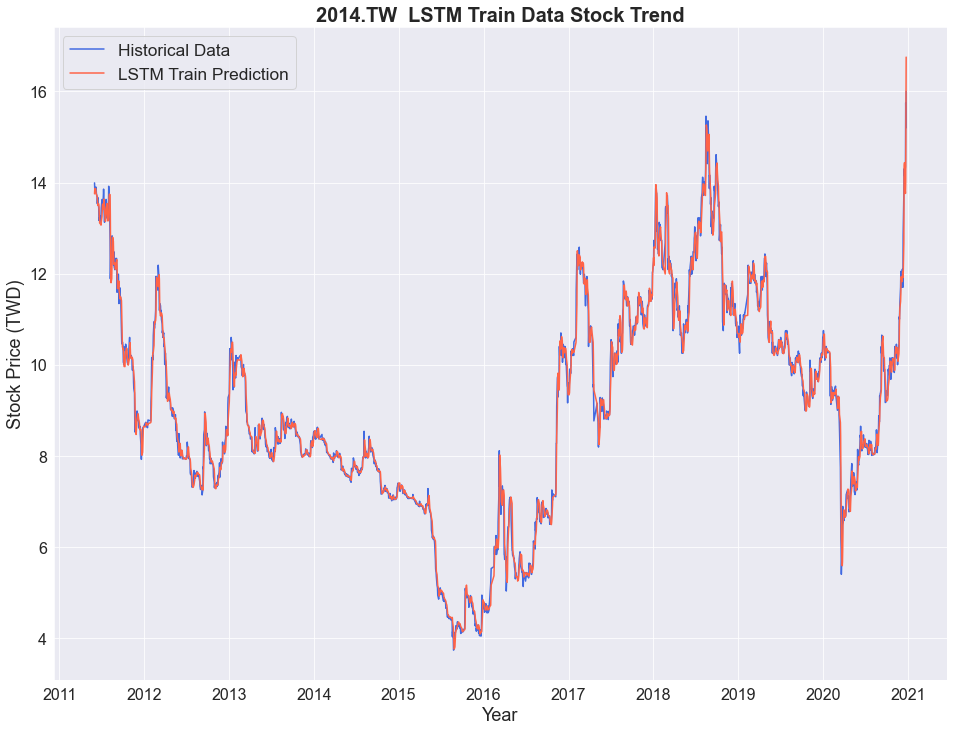

In [28]:
# Train_Data_Stock_Trend_Plot
Train_Data_Stock_Trend_Plot(y_train, all_y_train_pred[-1])

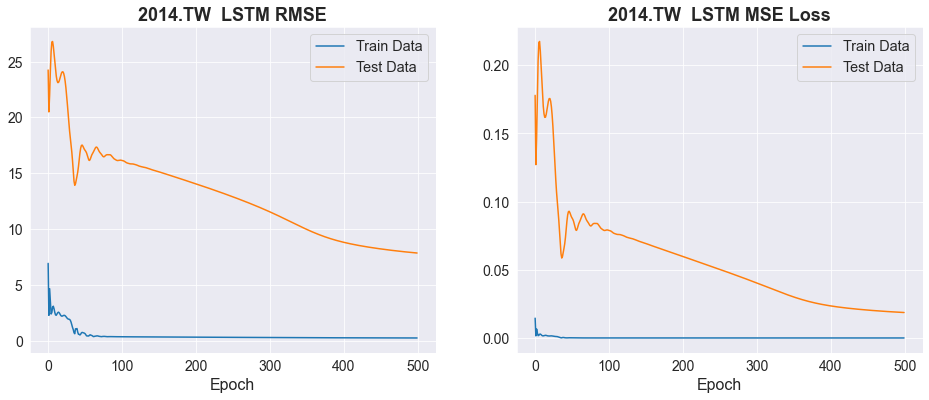

In [29]:
# RMSE_MSELOSS_Plot
RMSE_MSELOSS_Plot(allTrainRMSE, allTestRMSE, mseloss_train, mseloss_test)

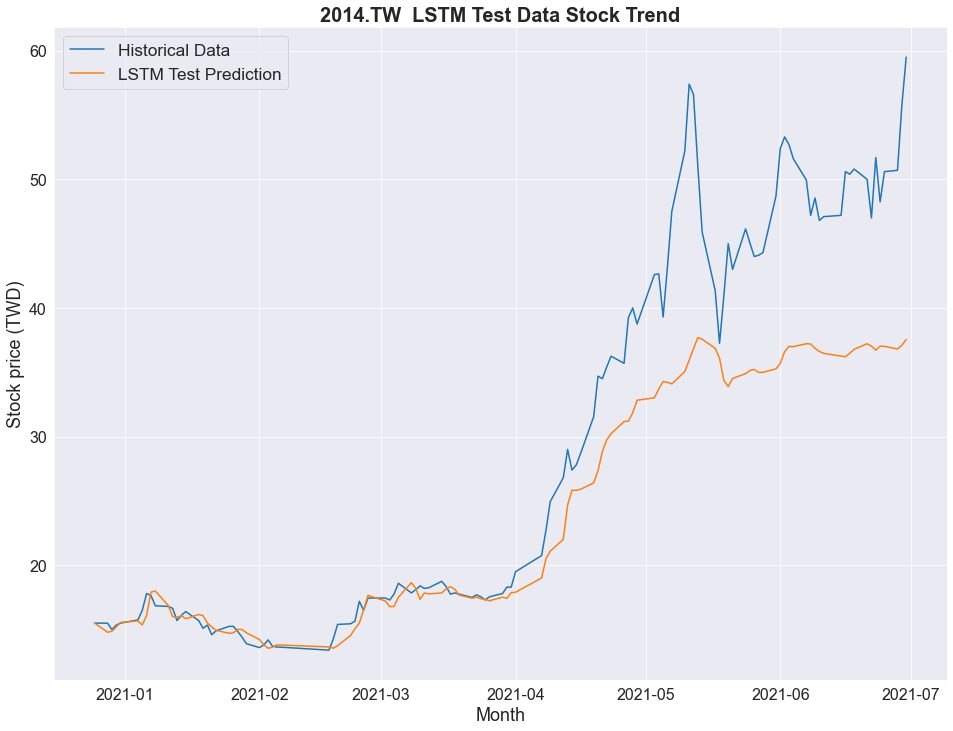

In [30]:
# Test_Data_Stock_Trend_Plot    
Test_Data_Stock_Trend_Plot(y_test, all_y_test_pred[-1]) 

In [31]:
# calculate root mean squared error
trainRMSE = math.sqrt(mean_squared_error(y_train[:,0], all_y_train_pred[i][:,0]))
testRMSE = math.sqrt(mean_squared_error(y_test[:,0], all_y_test_pred[i][:,0]))


trainR2 = r2_score(y_train[:,0], all_y_train_pred[-1][:,0])
testR2 = r2_score(y_test[:,0], all_y_test_pred[-1][:,0])


trainAdjR2 = 1-(1-trainR2)*((len(x_train)-1)/(len(x_train)-x_train.shape[2]-1))
testAdjR2 = 1-(1-testR2)*((len(x_test)-1)/(len(x_test)-x_test.shape[2]-1))


ldf = pd.DataFrame({'RMSE': [trainRMSE, testRMSE],
                    'R2 Score': [trainR2, testR2],
                    'Adj R2 Score': [trainAdjR2, testAdjR2]},
                   index=['Train', 'Test'])

ldf

# lstm.append(trainScore)
# lstm.append(testScore)
# lstm.append(training_time)

,RMSE,R2 Score,Adj R2 Score
Train,0.246767,0.989102,0.989078
Test,7.854632,0.723327,0.711192


In [32]:
lstmdata = all_y_test_pred[-1]

### GRU

In [33]:
model_name = 'GRU'

In [34]:
x_train, y_train, x_test, y_test = split_data(scaler_data, lookback=10, gapspace=0, test_set_size=120)

x_train.shape =  (2306, 9, 5)
y_train.shape =  (2306, 1)
x_test.shape =  (120, 9, 5)
y_test.shape =  (120, 1)


In [35]:
all_y_train_pred, all_y_test_pred, mseloss_train, mseloss_test = model_train_predict(epochs=500, model_name = 'GRU')

Epoch  10 MSE:  0.0016926428070291877
Epoch  20 MSE:  0.0018483723979443312
Epoch  30 MSE:  0.0007495803874917328
Epoch  40 MSE:  0.00014466795255430043
Epoch  50 MSE:  8.790376159595326e-05
Epoch  60 MSE:  7.142545655369759e-05
Epoch  70 MSE:  3.637866393546574e-05
Epoch  80 MSE:  3.63233448297251e-05
Epoch  90 MSE:  3.387065225979313e-05
Epoch  100 MSE:  3.2231619115918875e-05
Epoch  110 MSE:  3.129339529550634e-05
Epoch  120 MSE:  3.068370642722584e-05
Epoch  130 MSE:  3.001912045874633e-05
Epoch  140 MSE:  2.9372136850724928e-05
Epoch  150 MSE:  2.875428253901191e-05
Epoch  160 MSE:  2.8154723622719757e-05
Epoch  170 MSE:  2.7570569727686234e-05
Epoch  180 MSE:  2.70017480943352e-05
Epoch  190 MSE:  2.644889354996849e-05
Epoch  200 MSE:  2.591213706182316e-05
Epoch  210 MSE:  2.539154957048595e-05
Epoch  220 MSE:  2.488706559233833e-05
Epoch  230 MSE:  2.4398548703175038e-05
Epoch  240 MSE:  2.3925789719214663e-05
Epoch  250 MSE:  2.346853398194071e-05
Epoch  260 MSE:  2.3026495910

In [36]:
# invert data

if gpu_available == False:

    y_train = scalertar.inverse_transform(y_train.detach().numpy())
    y_test = scalertar.inverse_transform(y_test.detach().numpy())
    
else:

    y_train = scalertar.inverse_transform(y_train.cpu().detach().numpy())
    y_test = scalertar.inverse_transform(y_test.cpu().detach().numpy())

In [37]:
import math, time
from sklearn.metrics import mean_squared_error, r2_score

allTrainRMSE = []
allTestRMSE = []

for i in range(len(all_y_train_pred)):
    allTrainRMSE.append(math.sqrt(mean_squared_error(y_train[:,0], all_y_train_pred[i][:,0])))
    allTestRMSE.append(math.sqrt(mean_squared_error(y_test[:,0], all_y_test_pred[i][:,0])))

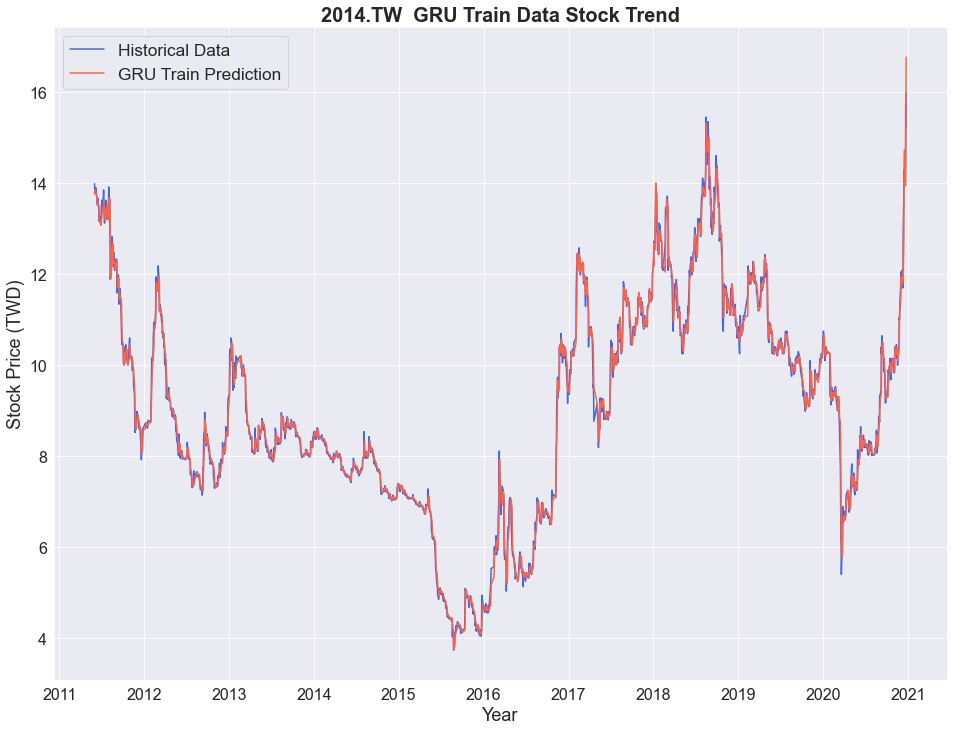

In [38]:
# Train_Data_Stock_Trend_Plot
Train_Data_Stock_Trend_Plot(y_train, all_y_train_pred[-1])

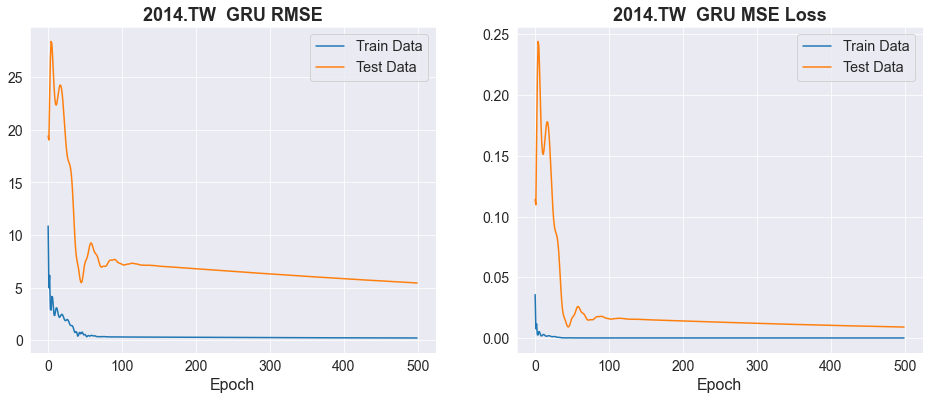

In [39]:
# RMSE_MSELOSS_Plot
RMSE_MSELOSS_Plot(allTrainRMSE, allTestRMSE, mseloss_train, mseloss_test)

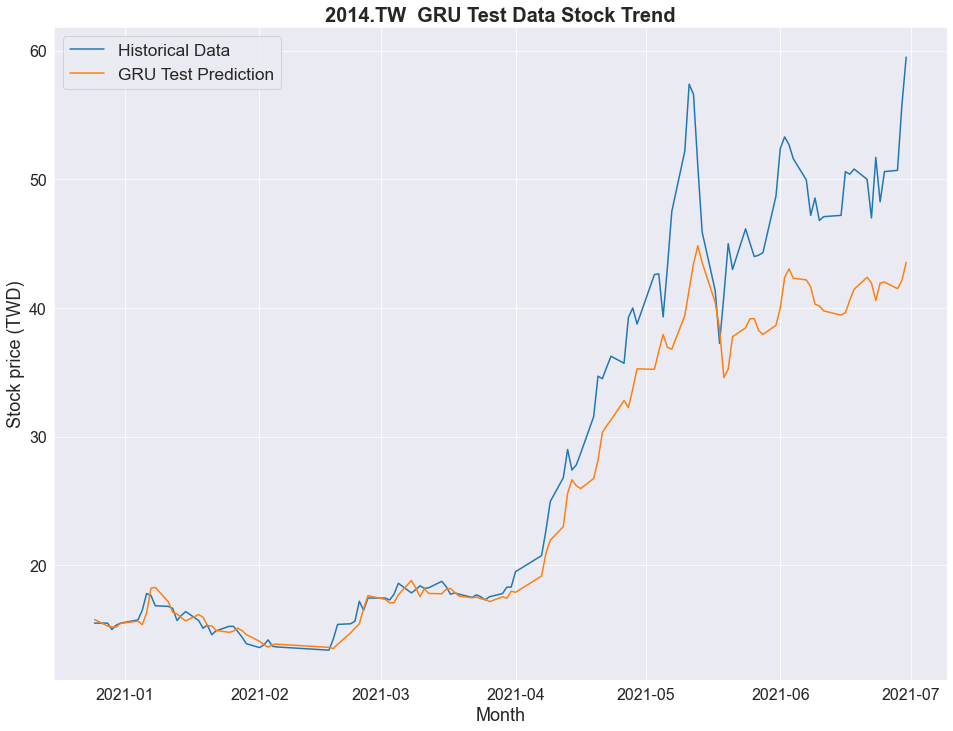

In [40]:
# Test_Data_Stock_Trend_Plot    
Test_Data_Stock_Trend_Plot(y_test, all_y_test_pred[-1]) 

In [41]:
# calculate root mean squared error
trainRMSE = math.sqrt(mean_squared_error(y_train[:,0], all_y_train_pred[i][:,0]))
testRMSE = math.sqrt(mean_squared_error(y_test[:,0], all_y_test_pred[i][:,0]))


trainR2 = r2_score(y_train[:,0], all_y_train_pred[-1][:,0])
testR2 = r2_score(y_test[:,0], all_y_test_pred[-1][:,0])


trainAdjR2 = 1-(1-trainR2)*((len(x_train)-1)/(len(x_train)-x_train.shape[2]-1))
testAdjR2 = 1-(1-testR2)*((len(x_test)-1)/(len(x_test)-x_test.shape[2]-1))


gdf = pd.DataFrame({'RMSE': [trainRMSE, testRMSE],
                    'R2 Score': [trainR2, testR2],
                    'Adj R2 Score': [trainAdjR2, testAdjR2]},
                   index=['Train', 'Test'])

gdf

# lstm.append(trainScore)
# lstm.append(testScore)
# lstm.append(training_time)

,RMSE,R2 Score,Adj R2 Score
Train,0.230468,0.990494,0.990473
Test,5.456346,0.866489,0.860633


In [42]:
ldf

,RMSE,R2 Score,Adj R2 Score
Train,0.246767,0.989102,0.989078
Test,7.854632,0.723327,0.711192


In [43]:
grudata = all_y_test_pred[-1]

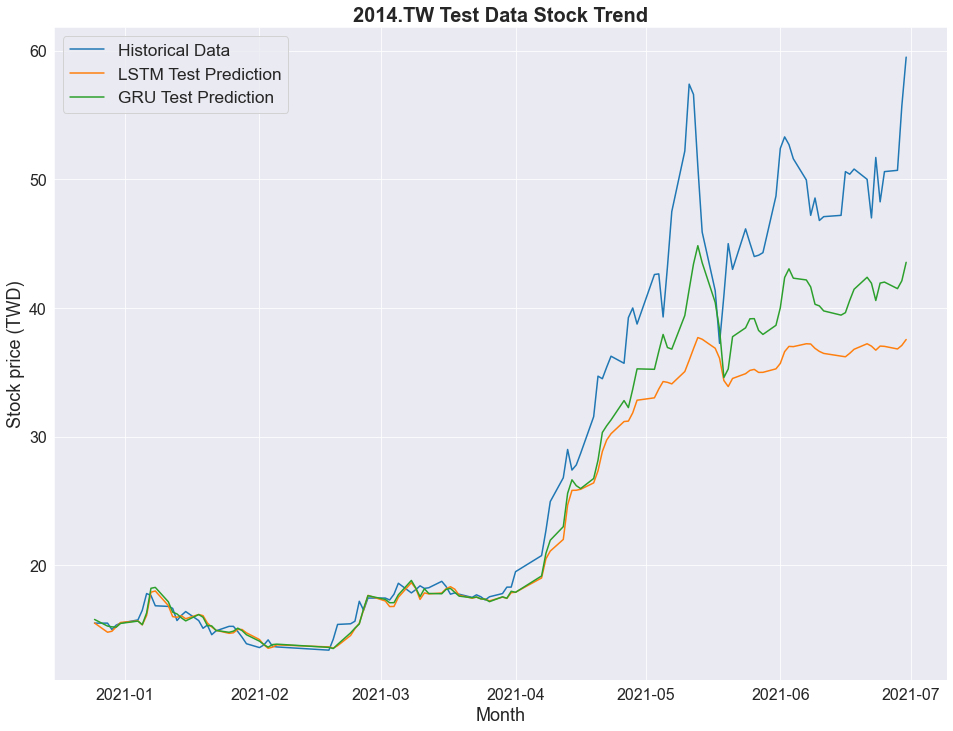

In [44]:
#  LSTM_GRU_Data_Stock_Trend_Plot
LSTM_GRU_Data_Stock_Trend_Plot(y_test, lstmdata, grudata)

##### just test

In [45]:
# load the model

# modelG = GRU(input_dim=df.shape[1], hidden_dim=32, output_dim=1, num_layers=2).to(device)
# modelG.load_state_dict(torch.load('data/model/GRU_epoch500.pth')) 

# y_test_pred = modelG(x_test)
# y_test_predG = scalertar.inverse_transform(y_test_pred.cpu().detach().numpy())

# y_test_predG
# all_y_test_pred[-1]